# Part 5 LSTM, GRU and RNN

In this notebook, we experimented with different models to find the best performing models. 

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

In [2]:
train_df = pd.read_csv("train.csv")
train_df.head()



,Score,Text
0,5,I received this product early from the seller!...
1,5,*****<br />Numi's Collection Assortment Melang...
2,5,"I was very careful not to overcook this pasta,..."
3,5,Buying this multi-pack I was misled by the pic...
4,5,These bars are so good! I loved them warmed up...


In [3]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM

# Preprocessing (Text vectorization)

In [4]:
VOCAB_SIZE = 10000  # Number of unique words to keep
SEQUENCE_LENGTH = 100  # Fixed length of input sequences

In [5]:
X_train = train_df['Text'].values
Y_train = train_df['Score'].values

In [6]:
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH  # Ensures uniform length
)

# Fit the TextVectorization layer to the text data
encoder.adapt(X_train)

In [7]:
vocab = np.array(encoder.get_vocabulary())
print(vocab[:20])  # Display the first 20 words

['' '[UNK]' 'the' 'i' 'and' 'a' 'to' 'it' 'of' 'is' 'this' 'in' 'for' 'my'
 'that' 'but' 'with' 'have' 'you' 'not']


In [8]:
# Sample text to test the encoder
sample_text = "This is a sample review."

# Use the encoder to transform the text into integers
encoded_text = encoder(tf.constant([sample_text]))

# Display the result
print(encoded_text.numpy())

[[  10    9    5 1073  378    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]


In [9]:
X_train_vectorized = encoder(X_train)

# Train-Val Split to check for overfitting

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split

# Ensure X_train_vectorized is a NumPy array
X_train_vectorized_np = X_train_vectorized.numpy() if isinstance(X_train_vectorized, tf.Tensor) else X_train_vectorized

# Split data into training and validation sets (80% training, 20% validation)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train_vectorized_np, Y_train, test_size=0.2, random_state=42
)


# Check if text is preprocessed properly

In [11]:
# Check the shape of X_train and X_val
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_val: {X_val.shape}")

# Print the first few tokenized sequences from X_train
print(f"Sample of tokenized X_train (first 3 samples):\n{X_train[:3]}")

# Print the first few tokenized sequences from X_val
print(f"Sample of tokenized X_val (first 3 samples):\n{X_val[:3]}")


Shape of X_train: (247304, 100)
Shape of X_val: (61827, 100)
Sample of tokenized X_train (first 3 samples):
[[   3   35  155    6  218   14    2  138 1679 5944  378    9   19   81
    18  265  136  214    8   33    2   78    8 2140   10  852 1644 6691
     4   14   73  117   46 2589   36   18  440   73  378  109 1261  128
   194  552   33   28  356  364    9  538   12    2 3904    2 6370 6565
    11    2  393    4 1767 1535  175   14   36  374 1185   21 2657  214
    32    2    1   24    2  532   59   71 7527  112  839    7  322   19
   763   26   46   37   96 2542   73  117   15  285   77  964   19  189
     7 1750]
 [  51  120    2  386 1354   26   14   51  130   99 1634  172   51   55
    29   42   23   21  188    6   72   87   40  296  718   51  211   53
    31  215   48    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    

In [12]:
print("Checking for missing values in X_train:")
print(np.any(np.isnan(X_train)))

print("Checking for missing values in X_val:")
print(np.any(np.isnan(X_val)))


Checking for missing values in X_train:
False
Checking for missing values in X_val:
False


In [18]:
# Check the length of tokenized sequences
train_lengths = [len(seq) for seq in X_train]
val_lengths = [len(seq) for seq in X_val]

print(f"Minimum length in X_train: {np.min(train_lengths)}")
print(f"Maximum length in X_train: {np.max(train_lengths)}")
print(f"Average length in X_train: {np.mean(train_lengths)}")

print(f"Minimum length in X_val: {np.min(val_lengths)}")
print(f"Maximum length in X_val: {np.max(val_lengths)}")
print(f"Average length in X_val: {np.mean(val_lengths)}")


Minimum length in X_train: 100
Maximum length in X_train: 100
Average length in X_train: 100.0
Minimum length in X_val: 100
Maximum length in X_val: 100
Average length in X_val: 100.0


In [19]:
# Check if any token exceeds VOCAB_SIZE
exceeds_vocab_train = np.any(X_train >= VOCAB_SIZE)
exceeds_vocab_val = np.any(X_val >= VOCAB_SIZE)

print(f"Any tokens in X_train exceed VOCAB_SIZE? {exceeds_vocab_train}")
print(f"Any tokens in X_val exceed VOCAB_SIZE? {exceeds_vocab_val}")


Any tokens in X_train exceed VOCAB_SIZE? False
Any tokens in X_val exceed VOCAB_SIZE? False


In [20]:
sample_text = ["This is a sample sentence.", "Another example sentence here."]
tokenized_sample = encoder(sample_text)

print(f"Tokenized Sample (before): {sample_text}")
print(f"Tokenized Sample (after): {tokenized_sample.numpy()}")


Tokenized Sample (before): ['This is a sample sentence.', 'Another example sentence here.']
Tokenized Sample (after): [[  10    9    5 1073    1    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 242 1967    1  204    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     

# Creating model **3rd best kaggle accuracy**

In [42]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(100,), dtype=tf.int32),  # Explicit input shape
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=64, mask_zero=True),  
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),  
    tf.keras.layers.Dense(64, activation='relu'),  
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')  
])

# Show model summary
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ (None, 100, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 128)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 714,629 (2.73 MB)

 Trainable params: 714,629 (2.73 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [44]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
Y_train_fixed = np.array(Y_train) - 1  # Shift labels from [1-5] to [0-4]
Y_val_fixed = np.array(Y_val) - 1  # Shift validation labels similarly

# Convert to one-hot encoding
Y_train_one_hot = to_categorical(Y_train_fixed, num_classes=5)
Y_val_one_hot = to_categorical(Y_val_fixed, num_classes=5)


# Now fit the model with one-hot encoded labels
history = model.fit(
    X_train, Y_train_one_hot,  # Use one-hot encoded labels
    validation_data=(X_val, Y_val_one_hot),
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 415s 53ms/step - accuracy: 0.6860 - loss: 0.8753 - val_accuracy: 0.7272 - val_loss: 0.7186
Epoch 2/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 359s 46ms/step - accuracy: 0.7364 - loss: 0.6918 - val_accuracy: 0.7363 - val_loss: 0.6971
Epoch 3/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 353s 46ms/step - accuracy: 0.7574 - loss: 0.6318 - val_accuracy: 0.7422 - val_loss: 0.6989
Epoch 4/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 385s 50ms/step - accuracy: 0.7769 - loss: 0.5807 - val_accuracy: 0.7327 - val_loss: 0.7309
Epoch 5/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 391s 51ms/step - accuracy: 0.7949 - loss: 0.5282 - val_accuracy: 0.7335 - val_loss: 0.7832
Epoch 6/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 398s 51ms/step - accuracy: 0.8153 - loss: 0.4783 - val_accuracy: 0.7319 - val_loss: 0.8268
Epoch 7/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 367s 48ms/step - accuracy: 0.8347 - loss: 0.4310 - val_accuracy: 0.7122 - val_loss: 0.9003
Epoch 8/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 377s 49ms/step - accuracy: 

# Submitting to kaggle the test.csv file

In [32]:
test = pd.read_csv('test.csv')

In [33]:
test.head()

,Id,Text
0,0,Fog chaser was the best both in flavor and bod...
1,1,"We found this at PF Changs, and it tastes just..."
2,2,Not quite a chocolate bar substitute but delic...
3,3,This is not as tasty as Pamela's Almond Biscot...
4,4,"<a href=""http://www.amazon.com/gp/product/B000..."


In [34]:


# Extract the text column
X_test = test["Text"].values  # Assuming 'Text' is the column name

# Apply the same TextVectorization layer
X_test_vectorized = encoder(X_test)  # Uses the same encoder from training


In [35]:
X_test_vectorized

<tf.Tensor: shape=(119662, 100), dtype=int64, numpy=
array([[4214, 4962,   20, ...,    0,    0,    0],
       [  51,  111,   10, ...,    0,    0,    0],
       [  19,  250,    5, ...,    0,    0,    0],
       ...,
       [   3,   55,  264, ...,    0,    0,    0],
       [  51,  103,    5, ...,    2,  279,  129],
       [   3,   82,   10, ...,    0,    0,    0]], dtype=int64)>

In [36]:
# Predict class probabilities
predictions = model.predict(X_test_vectorized)

# Convert probabilities to class labels
y_pred = predictions.argmax(axis=1)  # Get class index with highest probability

# If labels start from 1 (not 0), adjust
y_pred += 1  # Convert 0-based indices to 1-based labels


3740/3740 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step


In [37]:
sample_submission = pd.read_csv("sampleSubmission.csv")

# Replace the label column with predictions
sample_submission["Score"] = y_pred  # Ensure the column name matches Kaggle's expected output

# Save as submission.csv
sample_submission.to_csv("submission.csv", index=False)

print("Submission file saved as submission.csv ✅")

Submission file saved as submission.csv ✅


In [38]:
view_submitted=pd.read_csv('submission.csv')

In [39]:
view_submitted.describe()

,Id,Score
count,119662.000000,119662.000000
mean,59830.500000,4.192425
std,34543.588293,1.342349
min,0.000000,1.000000
25%,29915.250000,4.000000
50%,59830.500000,5.000000
75%,89745.750000,5.000000
max,119661.000000,5.000000


In [40]:
view_submitted.head()

,Id,Score
0,0,5
1,1,5
2,2,5
3,3,3
4,4,5


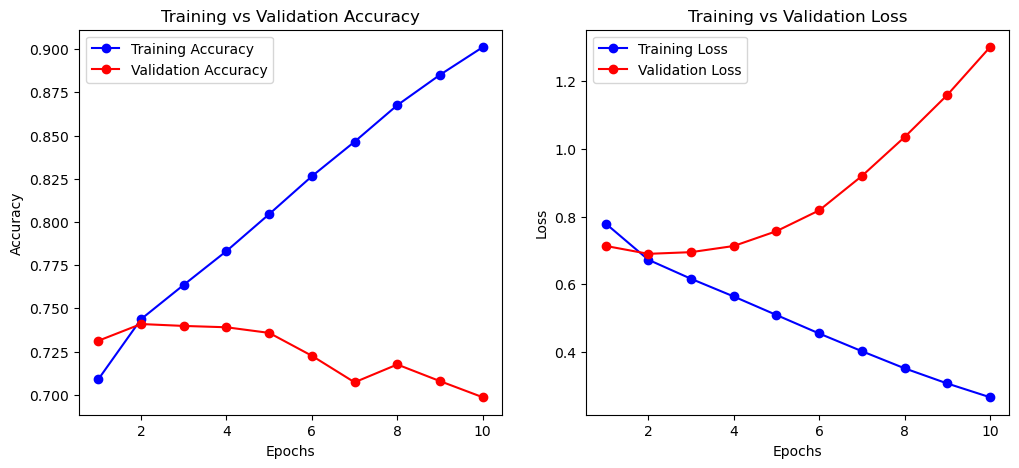

In [41]:
import matplotlib.pyplot as plt

# Extract accuracy and loss from training history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label="Training Accuracy")
plt.plot(epochs, val_acc, 'ro-', label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label="Training Loss")
plt.plot(epochs, val_loss, 'ro-', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")

plt.show()


# LSTM (more complex, adding regularisers, 5 epochs)

In [11]:
from tensorflow.keras import regularizers

model_lstm = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(100,), dtype=tf.int32),
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, 
        kernel_regularizer=regularizers.l2(0.001))),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),  # Second LSTM layer
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),  # Stronger dropout
    tf.keras.layers.Dense(5, activation='softmax')
])

model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 100, 128)            │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 751,749 (2.87 MB)

 Trainable params: 751,749 (2.87 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model_lstm.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [13]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
Y_train_fixed = np.array(Y_train) - 1  # Shift labels from [1-5] to [0-4]
Y_val_fixed = np.array(Y_val) - 1  # Shift validation labels similarly

# Convert to one-hot encoding
Y_train_one_hot = to_categorical(Y_train_fixed, num_classes=5)
Y_val_one_hot = to_categorical(Y_val_fixed, num_classes=5)


# Now fit the model with one-hot encoded labels
history = model_lstm.fit(
    X_train, Y_train_one_hot,  # Use one-hot encoded labels
    validation_data=(X_val, Y_val_one_hot),
    epochs=5,
    batch_size=32,
    verbose=1
)

Epoch 1/5
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 704s 89ms/step - accuracy: 0.6740 - loss: 0.9346 - val_accuracy: 0.7046 - val_loss: 0.7886
Epoch 2/5
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 590s 76ms/step - accuracy: 0.7176 - loss: 0.7658 - val_accuracy: 0.7254 - val_loss: 0.7444
Epoch 3/5
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 589s 76ms/step - accuracy: 0.7363 - loss: 0.7096 - val_accuracy: 0.7350 - val_loss: 0.7157
Epoch 4/5
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 592s 77ms/step - accuracy: 0.7460 - loss: 0.6791 - val_accuracy: 0.7291 - val_loss: 0.7304
Epoch 5/5
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 584s 76ms/step - accuracy: 0.7587 - loss: 0.6509 - val_accuracy: 0.7371 - val_loss: 0.7134


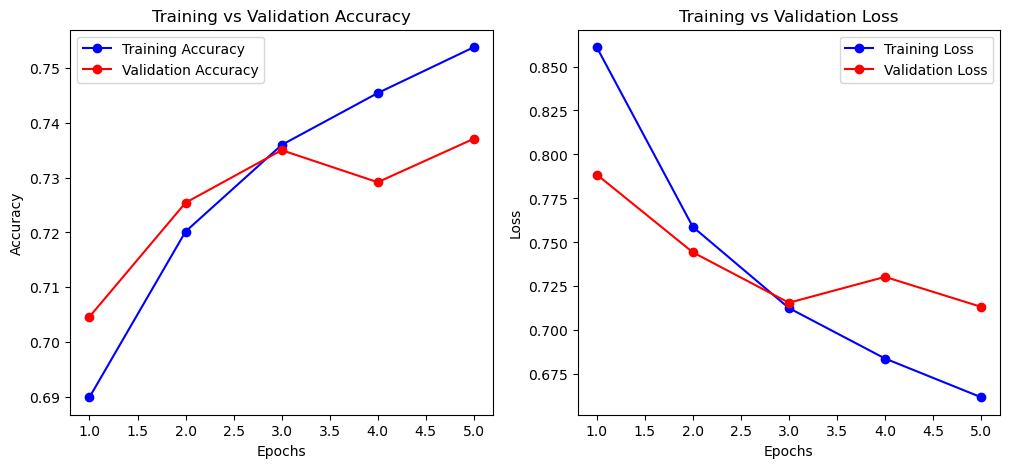

In [24]:
import matplotlib.pyplot as plt

# Extract accuracy and loss from training history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label="Training Accuracy")
plt.plot(epochs, val_acc, 'ro-', label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label="Training Loss")
plt.plot(epochs, val_loss, 'ro-', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")

plt.show()


In [14]:
test = pd.read_csv('test.csv')

In [15]:
test.head()

,Id,Text
0,0,Fog chaser was the best both in flavor and bod...
1,1,"We found this at PF Changs, and it tastes just..."
2,2,Not quite a chocolate bar substitute but delic...
3,3,This is not as tasty as Pamela's Almond Biscot...
4,4,"<a href=""http://www.amazon.com/gp/product/B000..."


In [16]:


# Extract the text column
X_test = test["Text"].values  # Assuming 'Text' is the column name

# Apply the same TextVectorization layer
X_test_vectorized = encoder(X_test)  # Uses the same encoder from training


In [17]:
X_test_vectorized

<tf.Tensor: shape=(119662, 100), dtype=int64, numpy=
array([[4214, 4962,   20, ...,    0,    0,    0],
       [  51,  111,   10, ...,    0,    0,    0],
       [  19,  250,    5, ...,    0,    0,    0],
       ...,
       [   3,   55,  264, ...,    0,    0,    0],
       [  51,  103,    5, ...,    2,  279,  129],
       [   3,   82,   10, ...,    0,    0,    0]], dtype=int64)>

In [18]:
# Predict class probabilities
predictions = model_lstm.predict(X_test_vectorized)

# Convert probabilities to class labels
y_pred = predictions.argmax(axis=1)  # Get class index with highest probability

# If labels start from 1 (not 0), adjust
y_pred += 1  # Convert 0-based indices to 1-based labels


3740/3740 ━━━━━━━━━━━━━━━━━━━━ 71s 19ms/step


In [19]:
sample_submission = pd.read_csv("sampleSubmission.csv")

# Replace the label column with predictions
sample_submission["Score"] = y_pred  # Ensure the column name matches Kaggle's expected output

# Save as submission.csv
sample_submission.to_csv("lstm_1.csv", index=False)

print("Submission file saved as lstm_1.csv ✅")

Submission file saved as lstm_1.csv ✅


In [20]:
view_submitted=pd.read_csv('lstm_1.csv')

In [21]:
view_submitted.head()

,Id,Score
0,0,5
1,1,5
2,2,5
3,3,2
4,4,5


# LSTM (same complexity, 10 epochs)

In [22]:
from tensorflow.keras import regularizers

model_lstm_10 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(100,), dtype=tf.int32),
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, 
        kernel_regularizer=regularizers.l2(0.001))),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),  # Second LSTM layer
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),  # Stronger dropout
    tf.keras.layers.Dense(5, activation='softmax')
])

model_lstm_10.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 100, 128)            │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 751,749 (2.87 MB)

 Trainable params: 751,749 (2.87 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model_lstm_10.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [25]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
Y_train_fixed = np.array(Y_train) - 1  # Shift labels from [1-5] to [0-4]
Y_val_fixed = np.array(Y_val) - 1  # Shift validation labels similarly

# Convert to one-hot encoding
Y_train_one_hot = to_categorical(Y_train_fixed, num_classes=5)
Y_val_one_hot = to_categorical(Y_val_fixed, num_classes=5)


# Now fit the model with one-hot encoded labels
history = model_lstm_10.fit(
    X_train, Y_train_one_hot,  # Use one-hot encoded labels
    validation_data=(X_val, Y_val_one_hot),
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 562s 70ms/step - accuracy: 0.6762 - loss: 0.9373 - val_accuracy: 0.7115 - val_loss: 0.7755
Epoch 2/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 541s 70ms/step - accuracy: 0.7165 - loss: 0.7675 - val_accuracy: 0.7311 - val_loss: 0.7273
Epoch 3/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 545s 71ms/step - accuracy: 0.7345 - loss: 0.7145 - val_accuracy: 0.7349 - val_loss: 0.7152
Epoch 4/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 570s 74ms/step - accuracy: 0.7468 - loss: 0.6805 - val_accuracy: 0.7354 - val_loss: 0.7175
Epoch 5/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 572s 74ms/step - accuracy: 0.7561 - loss: 0.6568 - val_accuracy: 0.7284 - val_loss: 0.7311
Epoch 6/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 591s 76ms/step - accuracy: 0.7627 - loss: 0.6362 - val_accuracy: 0.7385 - val_loss: 0.7205
Epoch 7/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 587s 76ms/step - accuracy: 0.7708 - loss: 0.6171 - val_accuracy: 0.7357 - val_loss: 0.7306
Epoch 8/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 570s 74ms/step - accuracy: 

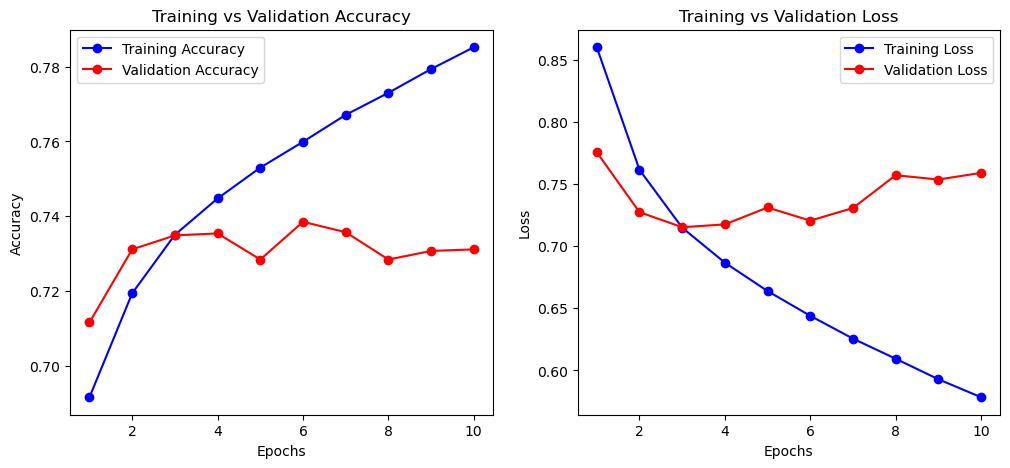

In [26]:
import matplotlib.pyplot as plt

# Extract accuracy and loss from training history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label="Training Accuracy")
plt.plot(epochs, val_acc, 'ro-', label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label="Training Loss")
plt.plot(epochs, val_loss, 'ro-', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")

plt.show()


In [27]:
X_test_vectorized

<tf.Tensor: shape=(119662, 100), dtype=int64, numpy=
array([[4214, 4962,   20, ...,    0,    0,    0],
       [  51,  111,   10, ...,    0,    0,    0],
       [  19,  250,    5, ...,    0,    0,    0],
       ...,
       [   3,   55,  264, ...,    0,    0,    0],
       [  51,  103,    5, ...,    2,  279,  129],
       [   3,   82,   10, ...,    0,    0,    0]], dtype=int64)>

In [28]:
# Predict class probabilities
predictions = model_lstm_10.predict(X_test_vectorized)

# Convert probabilities to class labels
y_pred = predictions.argmax(axis=1)  # Get class index with highest probability

# If labels start from 1 (not 0), adjust
y_pred += 1  # Convert 0-based indices to 1-based labels


3740/3740 ━━━━━━━━━━━━━━━━━━━━ 72s 19ms/step


In [29]:
sample_submission = pd.read_csv("sampleSubmission.csv")

# Replace the label column with predictions
sample_submission["Score"] = y_pred  # Ensure the column name matches Kaggle's expected output

# Save as submission.csv
sample_submission.to_csv("lstm_10.csv", index=False)

print("Submission file saved as lstm_10.csv ✅")

Submission file saved as lstm_10.csv ✅


In [30]:
view_submitted=pd.read_csv('lstm_10.csv')
view_submitted.head()

,Id,Score
0,0,5
1,1,5
2,2,5
3,3,3
4,4,5


# LSTM_11 (128 layers, lstm11.csv) **2nd best kaggle accuracy**

In [37]:
model_lstm11 = tf.keras.Sequential([
     tf.keras.layers.Input(shape=(100,), dtype=tf.int32),
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, recurrent_dropout=0.2)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='softmax')
])

model_lstm11.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 100, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 100, 256)            │         197,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,010,565 (3.85 MB)

 Trainable params: 1,010,565 (3.85 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
model_lstm11.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [39]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
Y_train_fixed = np.array(Y_train) - 1  # Shift labels from [1-5] to [0-4]
Y_val_fixed = np.array(Y_val) - 1  # Shift validation labels similarly

# Convert to one-hot encoding
Y_train_one_hot = to_categorical(Y_train_fixed, num_classes=5)
Y_val_one_hot = to_categorical(Y_val_fixed, num_classes=5)


# Now fit the model with one-hot encoded labels
history = model_lstm11.fit(
    X_train, Y_train_one_hot,  # Use one-hot encoded labels
    validation_data=(X_val, Y_val_one_hot),
    epochs=10,
    batch_size=32,
    verbose=1
 

Epoch 1/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 1011s 130ms/step - accuracy: 0.6879 - loss: 0.8630 - val_accuracy: 0.7355 - val_loss: 0.7041
Epoch 2/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 1368s 177ms/step - accuracy: 0.7380 - loss: 0.6883 - val_accuracy: 0.7413 - val_loss: 0.6899
Epoch 3/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 2688s 348ms/step - accuracy: 0.7588 - loss: 0.6322 - val_accuracy: 0.7470 - val_loss: 0.6733
Epoch 4/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 985s 127ms/step - accuracy: 0.7755 - loss: 0.5867 - val_accuracy: 0.7470 - val_loss: 0.6937
Epoch 5/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 952s 123ms/step - accuracy: 0.7910 - loss: 0.5413 - val_accuracy: 0.7381 - val_loss: 0.7225
Epoch 6/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 953s 123ms/step - accuracy: 0.8074 - loss: 0.5017 - val_accuracy: 0.7389 - val_loss: 0.7536
Epoch 7/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 1021s 132ms/step - accuracy: 0.8238 - loss: 0.4579 - val_accuracy: 0.7308 - val_loss: 0.8199
Epoch 8/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 988s 128ms/step 

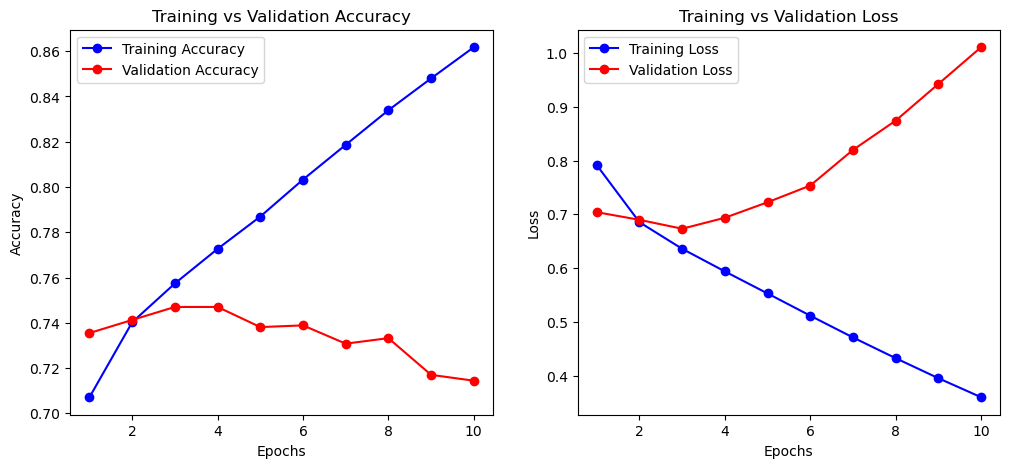

In [40]:
import matplotlib.pyplot as plt

# Extract accuracy and loss from training history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label="Training Accuracy")
plt.plot(epochs, val_acc, 'ro-', label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label="Training Loss")
plt.plot(epochs, val_loss, 'ro-', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")

plt.show()


In [41]:
X_test_vectorized

<tf.Tensor: shape=(119662, 100), dtype=int64, numpy=
array([[4214, 4962,   20, ...,    0,    0,    0],
       [  51,  111,   10, ...,    0,    0,    0],
       [  19,  250,    5, ...,    0,    0,    0],
       ...,
       [   3,   55,  264, ...,    0,    0,    0],
       [  51,  103,    5, ...,    2,  279,  129],
       [   3,   82,   10, ...,    0,    0,    0]], dtype=int64)>

In [42]:
# Predict class probabilities
predictions = model_lstm11.predict(X_test_vectorized)

# Convert probabilities to class labels
y_pred = predictions.argmax(axis=1)  # Get class index with highest probability

# If labels start from 1 (not 0), adjust
y_pred += 1  # Convert 0-based indices to 1-based labels


3740/3740 ━━━━━━━━━━━━━━━━━━━━ 159s 42ms/step


In [43]:
sample_submission = pd.read_csv("sampleSubmission.csv")

# Replace the label column with predictions
sample_submission["Score"] = y_pred  # Ensure the column name matches Kaggle's expected output

# Save as submission.csv
sample_submission.to_csv("lstm_11.csv", index=False)

print("Submission file saved as lstm_11.csv ✅")

Submission file saved as lstm_11.csv ✅


In [44]:
view_submitted=pd.read_csv('lstm_11.csv')
view_submitted.head()

,Id,Score
0,0,5
1,1,5
2,2,5
3,3,3
4,4,5


# LSTM_11 (but with 5 epochs, lstm12.csv) **best in terms of kaggle accuracy**

In [45]:
model_lstm12 = tf.keras.Sequential([
     tf.keras.layers.Input(shape=(100,), dtype=tf.int32),
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, recurrent_dropout=0.2)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='softmax')
])

model_lstm12.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 100, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_10 (Bidirectional)     │ (None, 100, 256)            │         197,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_11 (Bidirectional)     │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,010,565 (3.85 MB)

 Trainable params: 1,010,565 (3.85 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
model_lstm12.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [48]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
Y_train_fixed = np.array(Y_train) - 1  # Shift labels from [1-5] to [0-4]
Y_val_fixed = np.array(Y_val) - 1  # Shift validation labels similarly

# Convert to one-hot encoding
Y_train_one_hot = to_categorical(Y_train_fixed, num_classes=5)
Y_val_one_hot = to_categorical(Y_val_fixed, num_classes=5)


# Now fit the model with one-hot encoded labels
history = model_lstm11.fit(
    X_train, Y_train_one_hot,  # Use one-hot encoded labels
    validation_data=(X_val, Y_val_one_hot),
    epochs=5,
    batch_size=32,
    verbose=1
)

Epoch 1/5
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 999s 129ms/step - accuracy: 0.8815 - loss: 0.3101 - val_accuracy: 0.7087 - val_loss: 1.1286
Epoch 2/5
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 984s 127ms/step - accuracy: 0.8940 - loss: 0.2786 - val_accuracy: 0.7119 - val_loss: 1.1742
Epoch 3/5
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 1001s 130ms/step - accuracy: 0.9018 - loss: 0.2565 - val_accuracy: 0.7075 - val_loss: 1.2603
Epoch 4/5
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 1008s 130ms/step - accuracy: 0.9107 - loss: 0.2353 - val_accuracy: 0.7116 - val_loss: 1.3152
Epoch 5/5
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 1018s 132ms/step - accuracy: 0.9186 - loss: 0.2139 - val_accuracy: 0.7021 - val_loss: 1.4189


In [49]:
X_test_vectorized

<tf.Tensor: shape=(119662, 100), dtype=int64, numpy=
array([[4214, 4962,   20, ...,    0,    0,    0],
       [  51,  111,   10, ...,    0,    0,    0],
       [  19,  250,    5, ...,    0,    0,    0],
       ...,
       [   3,   55,  264, ...,    0,    0,    0],
       [  51,  103,    5, ...,    2,  279,  129],
       [   3,   82,   10, ...,    0,    0,    0]], dtype=int64)>

In [50]:
# Predict class probabilities
predictions = model_lstm11.predict(X_test_vectorized)

# Convert probabilities to class labels
y_pred = predictions.argmax(axis=1)  # Get class index with highest probability

# If labels start from 1 (not 0), adjust
y_pred += 1  # Convert 0-based indices to 1-based labels


3740/3740 ━━━━━━━━━━━━━━━━━━━━ 178s 48ms/step


In [51]:
sample_submission = pd.read_csv("sampleSubmission.csv")

# Replace the label column with predictions
sample_submission["Score"] = y_pred  # Ensure the column name matches Kaggle's expected output

# Save as submission.csv
sample_submission.to_csv("lstm_12.csv", index=False)

print("Submission file saved as lstm_12.csv ✅")

Submission file saved as lstm_12.csv ✅


In [52]:
view_submitted=pd.read_csv('lstm_12.csv')
view_submitted.head()

,Id,Score
0,0,5
1,1,5
2,2,5
3,3,3
4,4,5


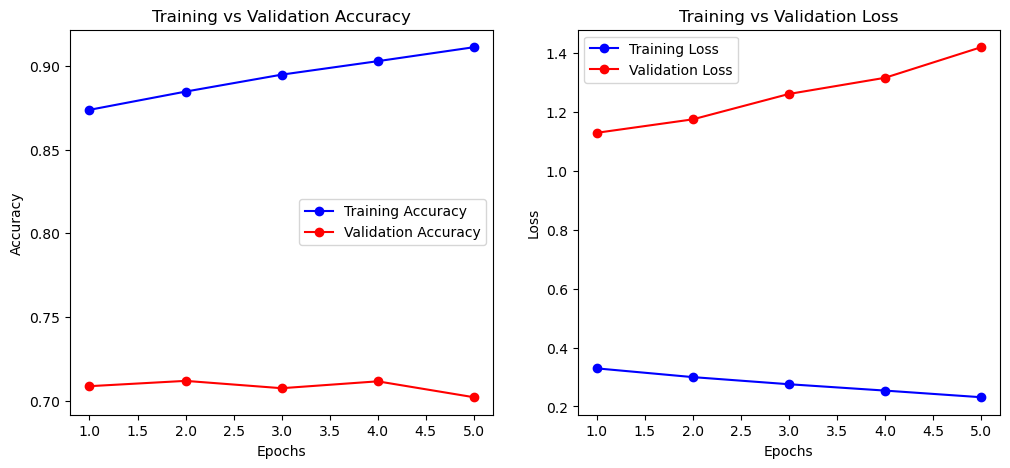

In [53]:
import matplotlib.pyplot as plt

# Extract accuracy and loss from training history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label="Training Accuracy")
plt.plot(epochs, val_acc, 'ro-', label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label="Training Loss")
plt.plot(epochs, val_loss, 'ro-', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")

plt.show()


# GRU (same complexity of LSTM_12) 5 epochs

In [13]:
model_gru = tf.keras.Sequential([
     tf.keras.layers.Input(shape=(100,), dtype=tf.int32),
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True, recurrent_dropout=0.2)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='softmax')
])

model_gru.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 100, 256)            │         148,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │         123,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 921,221 (3.51 MB)

 Trainable params: 921,221 (3.51 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model_gru.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [15]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
Y_train_fixed = np.array(Y_train) - 1  # Shift labels from [1-5] to [0-4]
Y_val_fixed = np.array(Y_val) - 1  # Shift validation labels similarly

# Convert to one-hot encoding
Y_train_one_hot = to_categorical(Y_train_fixed, num_classes=5)
Y_val_one_hot = to_categorical(Y_val_fixed, num_classes=5)


# Now fit the model with one-hot encoded labels
history = model_gru.fit(
    X_train, Y_train_one_hot,  # Use one-hot encoded labels
    validation_data=(X_val, Y_val_one_hot),
    epochs=5,
    batch_size=32,
    verbose=1
)

Epoch 1/5
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 1050s 133ms/step - accuracy: 0.6389 - loss: 1.0990 - val_accuracy: 0.6373 - val_loss: 1.1635
Epoch 2/5
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 1029s 133ms/step - accuracy: 0.6409 - loss: 1.0576 - val_accuracy: 0.6464 - val_loss: 1.0244
Epoch 3/5
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 1021s 132ms/step - accuracy: 0.6453 - loss: 1.0268 - val_accuracy: 0.6409 - val_loss: 1.0735
Epoch 4/5
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 972s 126ms/step - accuracy: 0.6499 - loss: 1.0260 - val_accuracy: 0.6263 - val_loss: 1.1445
Epoch 5/5
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 961s 124ms/step - accuracy: 0.6506 - loss: 1.0120 - val_accuracy: 0.6454 - val_loss: 1.0868


In [18]:
test = pd.read_csv('test.csv')

In [19]:
test.head()

,Id,Text
0,0,Fog chaser was the best both in flavor and bod...
1,1,"We found this at PF Changs, and it tastes just..."
2,2,Not quite a chocolate bar substitute but delic...
3,3,This is not as tasty as Pamela's Almond Biscot...
4,4,"<a href=""http://www.amazon.com/gp/product/B000..."


In [20]:
# Extract the text column
X_test = test["Text"].values  # Assuming 'Text' is the column name

# Apply the same TextVectorization layer
X_test_vectorized = encoder(X_test)  # Uses the same encoder from training


In [21]:
X_test_vectorized

<tf.Tensor: shape=(119662, 100), dtype=int64, numpy=
array([[4214, 4962,   20, ...,    0,    0,    0],
       [  51,  111,   10, ...,    0,    0,    0],
       [  19,  250,    5, ...,    0,    0,    0],
       ...,
       [   3,   55,  264, ...,    0,    0,    0],
       [  51,  103,    5, ...,    2,  279,  129],
       [   3,   82,   10, ...,    0,    0,    0]], dtype=int64)>

In [22]:
# Predict class probabilities
predictions = model_gru.predict(X_test_vectorized)

# Convert probabilities to class labels
y_pred = predictions.argmax(axis=1)  # Get class index with highest probability

# If labels start from 1 (not 0), adjust
y_pred += 1  # Convert 0-based indices to 1-based labels


3740/3740 ━━━━━━━━━━━━━━━━━━━━ 204s 54ms/step


In [23]:
sample_submission = pd.read_csv("sampleSubmission.csv")

# Replace the label column with predictions
sample_submission["Score"] = y_pred  # Ensure the column name matches Kaggle's expected output

# Save as submission.csv
sample_submission.to_csv("gru128.csv", index=False)

print("Submission file saved as gru128.csv ✅")

Submission file saved as gru128.csv ✅


In [24]:
view_submitted=pd.read_csv('gru128.csv')
view_submitted.head()

,Id,Score
0,0,5
1,1,5
2,2,5
3,3,5
4,4,5


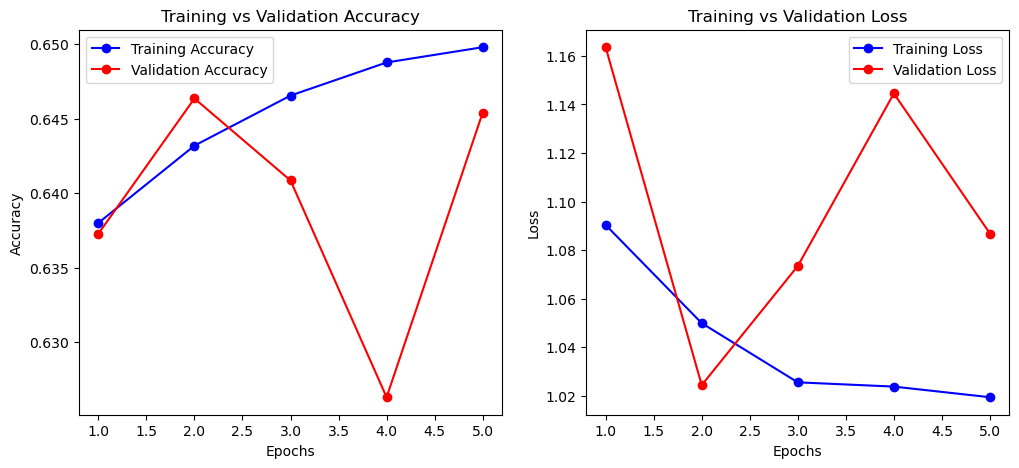

In [25]:
import matplotlib.pyplot as plt

# Extract accuracy and loss from training history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label="Training Accuracy")
plt.plot(epochs, val_acc, 'ro-', label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label="Training Loss")
plt.plot(epochs, val_loss, 'ro-', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")

plt.show()


# LSTM 11 (but with 1 epoch, saved as lstm13.csv)

In [26]:
model_lstm12 = tf.keras.Sequential([
     tf.keras.layers.Input(shape=(100,), dtype=tf.int32),
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, recurrent_dropout=0.2)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='softmax')
])

model_lstm12.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 100, 256)            │         197,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,010,565 (3.85 MB)

 Trainable params: 1,010,565 (3.85 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model_lstm12.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [31]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
Y_train_fixed = np.array(Y_train) - 1  # Shift labels from [1-5] to [0-4]
Y_val_fixed = np.array(Y_val) - 1  # Shift validation labels similarly

# Convert to one-hot encoding
Y_train_one_hot = to_categorical(Y_train_fixed, num_classes=5)
Y_val_one_hot = to_categorical(Y_val_fixed, num_classes=5)


# Now fit the model with one-hot encoded labels
history = model_lstm12.fit(
    X_train, Y_train_one_hot,  # Use one-hot encoded labels
    validation_data=(X_val, Y_val_one_hot),
    epochs=1,
    batch_size=32,
    verbose=1
)

7729/7729 ━━━━━━━━━━━━━━━━━━━━ 1149s 147ms/step - accuracy: 0.6872 - loss: 0.8674 - val_accuracy: 0.7322 - val_loss: 0.7143


In [32]:
X_test_vectorized

<tf.Tensor: shape=(119662, 100), dtype=int64, numpy=
array([[4214, 4962,   20, ...,    0,    0,    0],
       [  51,  111,   10, ...,    0,    0,    0],
       [  19,  250,    5, ...,    0,    0,    0],
       ...,
       [   3,   55,  264, ...,    0,    0,    0],
       [  51,  103,    5, ...,    2,  279,  129],
       [   3,   82,   10, ...,    0,    0,    0]], dtype=int64)>

In [33]:
# Predict class probabilities
predictions = model_lstm12.predict(X_test_vectorized)

# Convert probabilities to class labels
y_pred = predictions.argmax(axis=1)  # Get class index with highest probability

# If labels start from 1 (not 0), adjust
y_pred += 1  # Convert 0-based indices to 1-based labels


3740/3740 ━━━━━━━━━━━━━━━━━━━━ 139s 37ms/step


In [34]:
sample_submission = pd.read_csv("sampleSubmission.csv")

# Replace the label column with predictions
sample_submission["Score"] = y_pred  # Ensure the column name matches Kaggle's expected output

# Save as submission.csv
sample_submission.to_csv("lstm_13.csv", index=False)

print("Submission file saved as lstm_13.csv ✅")

Submission file saved as lstm_13.csv ✅


In [35]:
view_submitted=pd.read_csv('lstm_13.csv')
view_submitted.head()

,Id,Score
0,0,5
1,1,5
2,2,5
3,3,3
4,4,5


# LSTM (more complex, 256 layers)

In [36]:
model_lstm13 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(100,), dtype=tf.int32),
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True, recurrent_dropout=0.3)),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, recurrent_dropout=0.3)),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, recurrent_dropout=0.3)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='softmax')
])
model_lstm13.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 100, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 100, 512)            │         657,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization                  │ (None, 100, 512)            │           1,024 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 100, 256)            │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_1                │ (None, 100, 256)            │             512 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,144,773 (8.18 MB)

 Trainable params: 2,144,773 (8.18 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
model_lstm13.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [38]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
Y_train_fixed = np.array(Y_train) - 1  # Shift labels from [1-5] to [0-4]
Y_val_fixed = np.array(Y_val) - 1  # Shift validation labels similarly

# Convert to one-hot encoding
Y_train_one_hot = to_categorical(Y_train_fixed, num_classes=5)
Y_val_one_hot = to_categorical(Y_val_fixed, num_classes=5)


# Now fit the model with one-hot encoded labels
history = model_lstm13.fit(
    X_train, Y_train_one_hot,  # Use one-hot encoded labels
    validation_data=(X_val, Y_val_one_hot),
    epochs=5,
    batch_size=32,
    verbose=1
)

Epoch 1/5
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 4532s 585ms/step - accuracy: 0.6364 - loss: 1.1248 - val_accuracy: 0.6841 - val_loss: 0.8554
Epoch 2/5
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 3951s 511ms/step - accuracy: 0.6855 - loss: 0.8518 - val_accuracy: 0.6977 - val_loss: 0.7970
Epoch 3/5
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 3708s 480ms/step - accuracy: 0.7055 - loss: 0.7768 - val_accuracy: 0.7261 - val_loss: 0.7276
Epoch 4/5
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 3908s 506ms/step - accuracy: 0.7299 - loss: 0.7122 - val_accuracy: 0.7331 - val_loss: 0.7087
Epoch 5/5
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 4662s 603ms/step - accuracy: 0.7423 - loss: 0.6807 - val_accuracy: 0.7360 - val_loss: 0.7085


In [39]:
X_test_vectorized

<tf.Tensor: shape=(119662, 100), dtype=int64, numpy=
array([[4214, 4962,   20, ...,    0,    0,    0],
       [  51,  111,   10, ...,    0,    0,    0],
       [  19,  250,    5, ...,    0,    0,    0],
       ...,
       [   3,   55,  264, ...,    0,    0,    0],
       [  51,  103,    5, ...,    2,  279,  129],
       [   3,   82,   10, ...,    0,    0,    0]], dtype=int64)>

In [40]:
# Predict class probabilities
predictions = model_lstm13.predict(X_test_vectorized)

# Convert probabilities to class labels
y_pred = predictions.argmax(axis=1)  # Get class index with highest probability

# If labels start from 1 (not 0), adjust
y_pred += 1  # Convert 0-based indices to 1-based labels


3740/3740 ━━━━━━━━━━━━━━━━━━━━ 410s 109ms/step


In [41]:
sample_submission = pd.read_csv("sampleSubmission.csv")

# Replace the label column with predictions
sample_submission["Score"] = y_pred  # Ensure the column name matches Kaggle's expected output

# Save as submission.csv
sample_submission.to_csv("lstm_14.csv", index=False)

print("Submission file saved as lstm_14.csv ✅")

Submission file saved as lstm_14.csv ✅


In [42]:
view_submitted=pd.read_csv('lstm_14.csv')
view_submitted.head()

,Id,Score
0,0,5
1,1,5
2,2,5
3,3,3
4,4,5


# Basic RNN 

In [44]:
model_rnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(100,), dtype=tf.int32),
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=64, mask_zero=True),
    tf.keras.layers.SimpleRNN(128, return_sequences=True, dropout=0.2),
    tf.keras.layers.SimpleRNN(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='softmax')
])
model_rnn.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 100, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, 100, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ (None, 64)                  │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 681,541 (2.60 MB)

 Trainable params: 681,541 (2.60 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
model_rnn.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [46]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
Y_train_fixed = np.array(Y_train) - 1  # Shift labels from [1-5] to [0-4]
Y_val_fixed = np.array(Y_val) - 1  # Shift validation labels similarly

# Convert to one-hot encoding
Y_train_one_hot = to_categorical(Y_train_fixed, num_classes=5)
Y_val_one_hot = to_categorical(Y_val_fixed, num_classes=5)


# Now fit the model with one-hot encoded labels
history = model_rnn.fit(
    X_train, Y_train_one_hot,  # Use one-hot encoded labels
    validation_data=(X_val, Y_val_one_hot),
    epochs=5,
    batch_size=32,
    verbose=1
)

Epoch 1/5
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 290s 36ms/step - accuracy: 0.6395 - loss: 1.0807 - val_accuracy: 0.6561 - val_loss: 0.9358
Epoch 2/5
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 285s 37ms/step - accuracy: 0.6582 - loss: 0.9629 - val_accuracy: 0.6582 - val_loss: 0.9754
Epoch 3/5
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 285s 37ms/step - accuracy: 0.6452 - loss: 1.0115 - val_accuracy: 0.6618 - val_loss: 0.9817
Epoch 4/5
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 289s 37ms/step - accuracy: 0.6516 - loss: 1.0004 - val_accuracy: 0.6645 - val_loss: 0.9884
Epoch 5/5
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 290s 38ms/step - accuracy: 0.6639 - loss: 0.9480 - val_accuracy: 0.6746 - val_loss: 0.9148


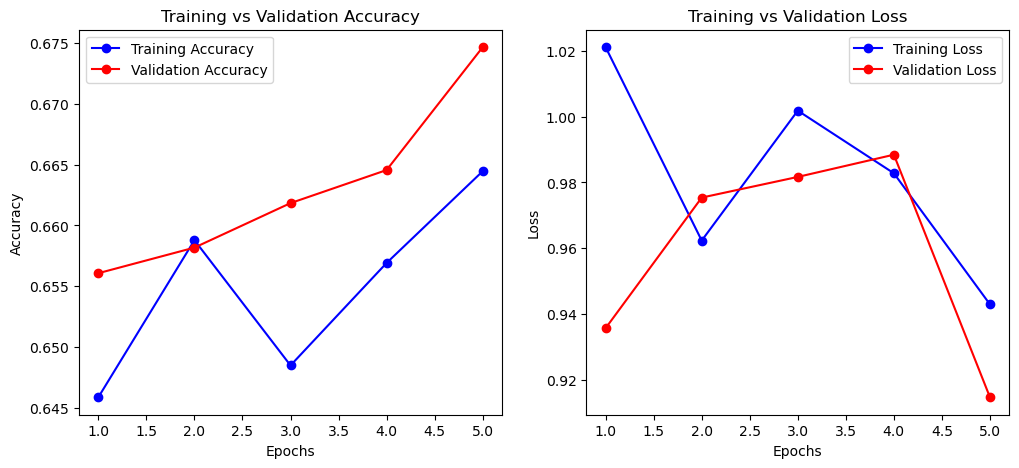

In [49]:
import matplotlib.pyplot as plt

# Extract accuracy and loss from training history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label="Training Accuracy")
plt.plot(epochs, val_acc, 'ro-', label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label="Training Loss")
plt.plot(epochs, val_loss, 'ro-', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")

plt.show()


In [50]:
X_test_vectorized

<tf.Tensor: shape=(119662, 100), dtype=int64, numpy=
array([[4214, 4962,   20, ...,    0,    0,    0],
       [  51,  111,   10, ...,    0,    0,    0],
       [  19,  250,    5, ...,    0,    0,    0],
       ...,
       [   3,   55,  264, ...,    0,    0,    0],
       [  51,  103,    5, ...,    2,  279,  129],
       [   3,   82,   10, ...,    0,    0,    0]], dtype=int64)>

In [51]:
# Predict class probabilities
predictions = model_rnn.predict(X_test_vectorized)

# Convert probabilities to class labels
y_pred = predictions.argmax(axis=1)  # Get class index with highest probability

# If labels start from 1 (not 0), adjust
y_pred += 1  # Convert 0-based indices to 1-based labels


3740/3740 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step


In [52]:
sample_submission = pd.read_csv("sampleSubmission.csv")

# Replace the label column with predictions
sample_submission["Score"] = y_pred  # Ensure the column name matches Kaggle's expected output

# Save as submission.csv
sample_submission.to_csv("rnn.csv", index=False)

print("Submission file saved as rnn.csv ✅")

Submission file saved as rnn.csv ✅


# LSTM (256 layers, but train it for 10 epochs)

In [53]:
model_lstm13.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [54]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
Y_train_fixed = np.array(Y_train) - 1  # Shift labels from [1-5] to [0-4]
Y_val_fixed = np.array(Y_val) - 1  # Shift validation labels similarly

# Convert to one-hot encoding
Y_train_one_hot = to_categorical(Y_train_fixed, num_classes=5)
Y_val_one_hot = to_categorical(Y_val_fixed, num_classes=5)


# Now fit the model with one-hot encoded labels
history = model_lstm13.fit(
    X_train, Y_train_one_hot,  # Use one-hot encoded labels
    validation_data=(X_val, Y_val_one_hot),
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 4189s 540ms/step - accuracy: 0.7525 - loss: 0.6540 - val_accuracy: 0.7342 - val_loss: 0.7102
Epoch 2/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 4602s 595ms/step - accuracy: 0.7607 - loss: 0.6265 - val_accuracy: 0.7341 - val_loss: 0.7230
Epoch 3/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 4644s 601ms/step - accuracy: 0.7699 - loss: 0.6018 - val_accuracy: 0.7374 - val_loss: 0.7132
Epoch 4/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 4697s 608ms/step - accuracy: 0.7799 - loss: 0.5794 - val_accuracy: 0.7320 - val_loss: 0.7295
Epoch 5/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 4712s 610ms/step - accuracy: 0.7863 - loss: 0.5596 - val_accuracy: 0.7324 - val_loss: 0.7461
Epoch 6/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 4644s 601ms/step - accuracy: 0.7946 - loss: 0.5414 - val_accuracy: 0.7294 - val_loss: 0.7663
Epoch 7/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 4687s 606ms/step - accuracy: 0.8009 - loss: 0.5234 - val_accuracy: 0.7336 - val_loss: 0.7901
Epoch 8/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 4776s 618ms/s

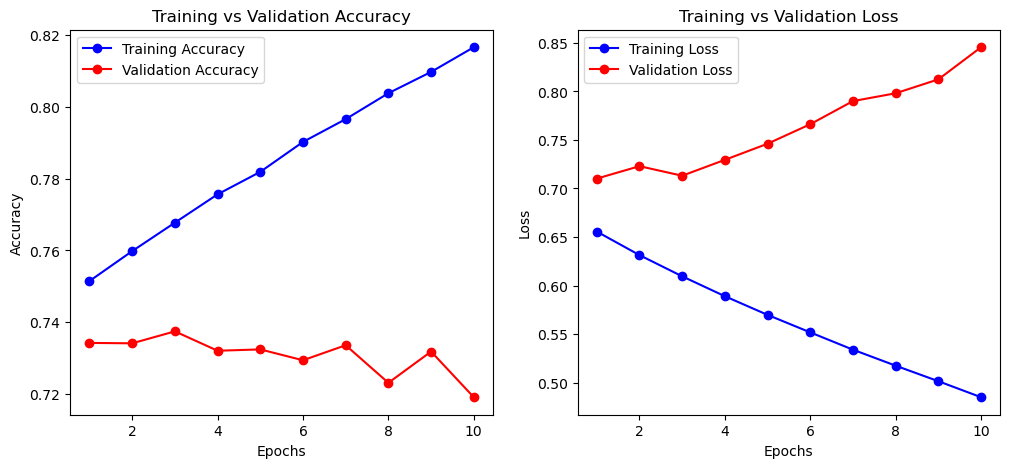

In [55]:
import matplotlib.pyplot as plt

# Extract accuracy and loss from training history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label="Training Accuracy")
plt.plot(epochs, val_acc, 'ro-', label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label="Training Loss")
plt.plot(epochs, val_loss, 'ro-', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")

plt.show()


In [56]:
X_test_vectorized

<tf.Tensor: shape=(119662, 100), dtype=int64, numpy=
array([[4214, 4962,   20, ...,    0,    0,    0],
       [  51,  111,   10, ...,    0,    0,    0],
       [  19,  250,    5, ...,    0,    0,    0],
       ...,
       [   3,   55,  264, ...,    0,    0,    0],
       [  51,  103,    5, ...,    2,  279,  129],
       [   3,   82,   10, ...,    0,    0,    0]], dtype=int64)>

In [58]:
# Predict class probabilities
predictions = model_lstm13.predict(X_test_vectorized)

# Convert probabilities to class labels
y_pred = predictions.argmax(axis=1)  # Get class index with highest probability

# If labels start from 1 (not 0), adjust
y_pred += 1  # Convert 0-based indices to 1-based labels


3740/3740 ━━━━━━━━━━━━━━━━━━━━ 782s 209ms/step


In [59]:
sample_submission = pd.read_csv("sampleSubmission.csv")

# Replace the label column with predictions
sample_submission["Score"] = y_pred  # Ensure the column name matches Kaggle's expected output

# Save as submission.csv
sample_submission.to_csv("lstm_256.csv", index=False)

print("Submission file saved as lstm_256.csv ✅")

Submission file saved as lstm_256.csv ✅


In [60]:
view_submitted=pd.read_csv('lstm_256.csv')
view_submitted.head()

,Id,Score
0,0,5
1,1,5
2,2,5
3,3,3
4,4,5
